---
authors:
  - name: Mathis Derenne
    affiliation: M2 MIASHS - Université de Lyon
    github: mathisdrn
  - name: Djida Boukari
    affiliation: M2 MIASHS - Université de Lyon
  - name: Ines Nakhli
    affiliation: M2 MIASHS - Université de Lyon
date: 2026-02-01
---

# Modèle de Cox

Ce notebook implémente un modèle de Cox pour prédire les risques de survie à partir de données censurées.

On fait une recherche par grille avec validation croisée pour déterminer le coefficient de penalité et la méthode de régularisation (L1, L2 ou ElasticNet).

En pratique, il faudrait standardiser les données sur chaque pli. En l'état une standardisation globale est faite avant la séparation des données, ce qui peut entraîner une légère fuite de données. Toutefois, la librairie `lifelines` ne supporte pas les pipelines scikit-learn, ce qui complique l'implémentation.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

# Polars display options
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(3)
pl.Config.set_tbl_hide_column_data_types(True);

## Chargement des données

In [2]:
X_train = pl.read_parquet("../../data/df_study_L18_w6_train.parquet")
X_test = pl.read_parquet("../../data/df_study_L18_w6_test.parquet")

## Entraînement du modèle

In [3]:
from itertools import product

from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from tqdm.auto import tqdm

penalizers = [0.1, 1.0]
l1_ratios = [0.0, 0.5, 1.0]
grid = list(product(penalizers, l1_ratios))

results = []

# Pour réduire le temps d'exécution.
X_train_sub = X_train.sample(fraction=0.4, seed=42)

for p, l1 in tqdm(grid, desc="Hyperparameter tuning"):
    cph = CoxPHFitter(alpha=0.05, penalizer=p, l1_ratio=l1)

    scores = k_fold_cross_validation(
        cph,
        X_train_sub.to_pandas(),
        duration_col="time",
        event_col="event",
        k=2,
        scoring_method="concordance_index",
    )

    results.append(
        {
            "penalizer": p,
            "l1_ratio": l1,
            "mean_c_index": np.mean(scores),
            "std_err": np.std(scores),
        }
    )

pl.DataFrame(results).sort("mean_c_index", descending=True)

Hyperparameter tuning:   0%|          | 0/6 [00:00<?, ?it/s]

penalizer,l1_ratio,mean_c_index,std_err
0.100,1.000,0.698,0.011
0.100,0.500,0.698,0.012
1.000,1.000,0.673,0.004
1.000,0.000,0.657,0.002
1.000,0.500,0.650,0.000
0.100,0.000,0.641,0.009


Dans l'ordre de performance, le meilleur modèle est un modèle de Cox pénalisé avec un coefficient de pénalisation de 0.1 et une régularisation ElasticNet (poids L1 = 0.5), suivi d'un modèle de Cox L1 avec un coefficient de pénalisation de 0.1.

## Entraînement du modèle final

On utilise un coefficient de pénalisation de 0.1 avec une régularisation ElasticNet.

In [4]:
cph = CoxPHFitter(alpha=0.05, penalizer=0.1, l1_ratio=0.5)
cph.fit(X_train.to_pandas(), duration_col="time", event_col="event")

<lifelines.CoxPHFitter: fitted with 2381 total observations, 780 right-censored observations>

## Évaluation du modèle final

In [ ]:
from utils import evaluate_survival_model

risk_cox = cph.predict_partial_hazard(X_test.to_pandas())
surv_cox = cph.predict_survival_function(X_test.to_pandas())
evaluate_survival_model(X_train, X_test, risk_cox, surv_cox)

C-index,Mean td-AUC,IBS,Brier (t=1191.0)
0.700,0.760,0.180,0.200


In [ ]:
ll_ratio_test = cph.log_likelihood_ratio_test()

metrics = {
    "Concordance": cph.concordance_index_,
    "Partial AIC": cph.AIC_partial_,
    "log-likelihood ratio test": ll_ratio_test.test_statistic,
    "p-value (test)": ll_ratio_test.p_value,
    "-log2(p) of II-ratio test": ll_ratio_test.summary["-log2(p)"].to_numpy()[0],
}
pl.DataFrame(metrics, orient="row")

Concordance,Partial AIC,log-likelihood ratio test,p-value (test),-log2(p) of II-ratio test
0.723,22434.790,321.967,0.751,0.413


In [7]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pca0,9.361872e-02,1.098141,0.008050,0.077840,0.109397,1.080950,1.115605,0.0,11.629020,2.934455e-31,101.426679
pca1,-1.070937e-08,1.000000,0.000008,-0.000016,0.000016,0.999984,1.000016,0.0,-0.001328,9.989404e-01,0.001530
pca2,-1.010122e-01,0.903922,0.009618,-0.119864,-0.082161,0.887041,0.921124,0.0,-10.502084,8.449369e-26,83.291287
pca3,7.799587e-03,1.007830,0.008405,-0.008673,0.024272,0.991365,1.024569,0.0,0.928024,3.533949e-01,1.500647
pca4,-6.778323e-09,1.000000,0.000007,-0.000014,0.000014,0.999986,1.000014,0.0,-0.000977,9.992204e-01,0.001125
...,...,...,...,...,...,...,...,...,...,...,...
pca335,-1.542016e-09,1.000000,0.000024,-0.000046,0.000046,0.999954,1.000046,0.0,-0.000065,9.999479e-01,0.000075
pca336,3.216029e-08,1.000000,0.000029,-0.000057,0.000057,0.999943,1.000057,0.0,0.001109,9.991150e-01,0.001277
pca337,2.872683e-09,1.000000,0.000024,-0.000046,0.000046,0.999954,1.000046,0.0,0.000121,9.999034e-01,0.000139


In [8]:
cph.baseline_survival_

,baseline survival
540.0,0.998496
541.0,0.998119
543.0,0.997365
545.0,0.996234
546.0,0.995479
...,...
10627.0,0.012385
10786.0,0.009362
11143.0,0.009362
11155.0,0.009362


## Courbe de calibration

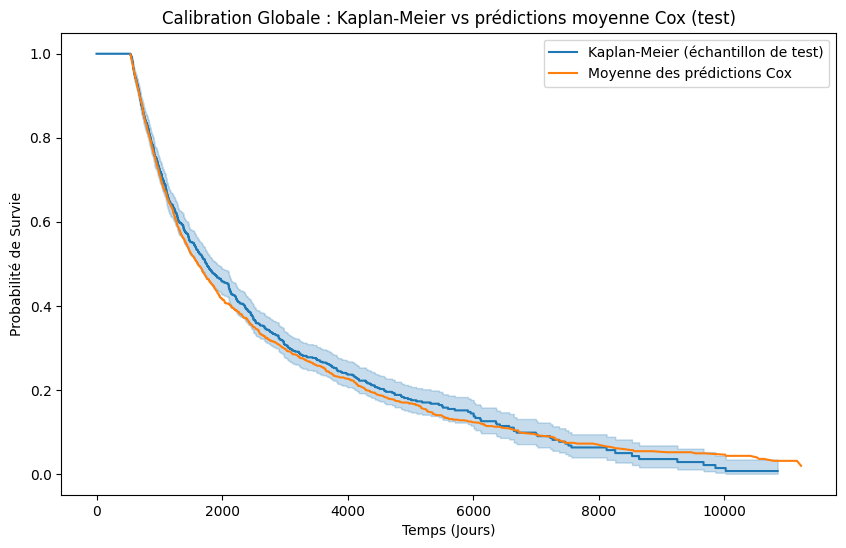

In [9]:
from lifelines import KaplanMeierFitter

df_test = X_test.to_pandas()

# Kaplan-Meier sur l'échantillon de test
kmf = KaplanMeierFitter()
kmf.fit(
    durations=df_test["time"],
    event_observed=df_test["event"],
    label="Kaplan-Meier (échantillon de test)",
)

# Prédictions du modèle Cox
predicted_surv_curves = cph.predict_survival_function(df_test)

# Survie moyenne prédite par le modèle pour toute la cohorte
average_predicted_survival = predicted_surv_curves.mean(axis=1)

# Visualisation
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ax=plt.gca(), ci_show=True)
plt.plot(
    average_predicted_survival.index,
    average_predicted_survival.values,
    label="Moyenne des prédictions Cox",
)

plt.title("Calibration Globale : Kaplan-Meier vs prédictions moyenne Cox (test)")
plt.xlabel("Temps (Jours)")
plt.ylabel("Probabilité de Survie")
plt.legend();

In [10]:
# Choix du temps t0 comme la médiane des temps d'événements observés dans le jeu de test
t0 = X_test.get_column("time").quantile(0.5)

# On vérifie la plage des prédictions à t0
predictions = cph.predict_survival_function(X_test.to_pandas(), times=[t0]).T
predictions.describe()

,1380.0
count,1174.000000
mean,0.561235
std,0.135147
min,0.170072
25%,0.468622
50%,0.541199
75%,0.655733
max,0.925682


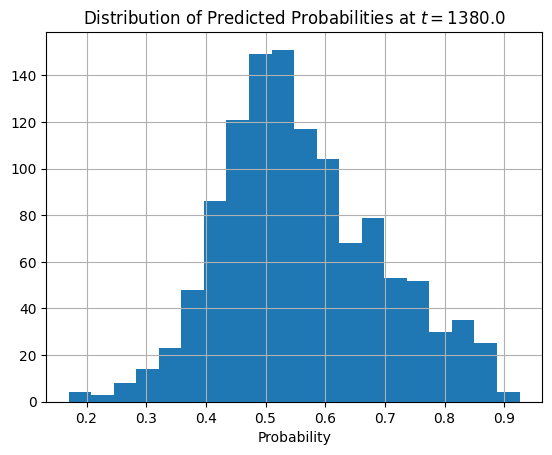

In [11]:
predictions.hist(bins=20)
plt.title(f"Distribution of Predicted Probabilities at $t={t0}$")
plt.xlabel("Probability");

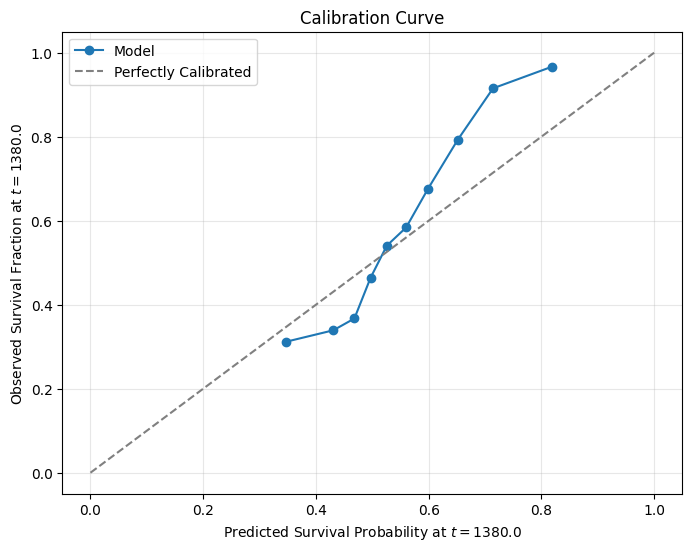

In [ ]:
def manual_calibration_plot(
    model: CoxPHFitter, data: pd.DataFrame, t0: float, n_bins: int = 10
) -> None:
    # 1. On prédit les probabilités de survie à t0
    predictions = model.predict_survival_function(data, times=[t0]).T.iloc[:, 0]

    # 2. Catégoriser les prédictions
    data["pred_prob"] = predictions
    data["bin"] = pd.qcut(data["pred_prob"], n_bins, duplicates="drop")

    bin_centers = []
    observed_rates = []

    # 3. Calcul des taux observés de survie avec Kaplan-Meier
    for _, group in data.groupby("bin"):
        kmf = KaplanMeierFitter().fit(group["time"], group["event"])
        # Get KM survival estimate at t0
        observed_rates.append(kmf.predict(t0))
        bin_centers.append(group["pred_prob"].mean())

    # 4. Rendu
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, observed_rates, marker="o", linestyle="-", label="Model")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly Calibrated")

    plt.xlabel(f"Predicted Survival Probability at $t={t0}$")
    plt.ylabel(f"Observed Survival Fraction at $t={t0}$")
    plt.title("Calibration Curve")
    plt.legend()
    plt.grid(visible=True, alpha=0.3)
    plt.show()


t0 = X_test.get_column("time").quantile(0.5)
manual_calibration_plot(cph, X_test.to_pandas(), t0=t0)